In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'/home/bradhakrishnan/ECE276A_PR1/code/')

In [3]:
import motion_calibration
import load_data
import jax
import jax.numpy as jnp
import quaternion_ops as qops 
import numpy as np
from tqdm import tqdm
dataset_idx= 9
jax.config.update("jax_enable_x64", True)


In [4]:
from load_data import load_dataset
imud,vicd, cam=load_dataset(dataset_idx)

Data import took: 1.062232255935669 sec.



In [5]:
def pan_creation(vicd, cam):
    # Time sync.
    cam_ts_2_vicd_ts_idx = {}
    for cam_idx, cam_ts in enumerate(cam['ts'][0]):
        temp = jnp.abs(vicd['ts'][0] - cam_ts)
        vicd_idx = jnp.argmin(temp)
        cam_ts_2_vicd_ts_idx[cam_idx] = vicd_idx

    img_h, img_w, vert_angle_lim, hor_angle_lim= 240,320,45.0,60.0
    W_pan=1920
    H_pan=960
    y_angles= np.linspace(90-(vert_angle_lim/2), 90+(vert_angle_lim/2)-1, int(img_h))*np.pi/180
    x_angles= np.linspace(90-(hor_angle_lim/2), 90+(hor_angle_lim/2)-1, int(img_w))*np.pi/180
    lambda_map, phi_map = np.meshgrid(x_angles, y_angles)
    cartesian_coords = np.stack([
        np.multiply(np.cos(phi_map),np.cos(lambda_map)),
        np.multiply(np.cos(phi_map),np.sin(lambda_map)),
        np.sin(phi_map)
    ], axis=-1)
    
    # now take all rotation matrices and use them to rotate the cartesian coords. 
    world_frame_cart = np.zeros(cam['cam'].shape)
    for frame_idx in range(cam['cam'].shape[-1]):
        R= vicd['rots'][:,:,cam_ts_2_vicd_ts_idx[frame_idx]]
        world_frame_cart[:,:,:,frame_idx]= np.dot(cartesian_coords, R)

    # Now we need to get the rotated cartesian to spherical 
    spher_cart_world= np.zeros(cam['cam'].shape)
    #finding what radius to use this is sqrt(x^2+y^2+z^2)
    spher_cart_world[:,:,0,:]= np.linalg.norm(world_frame_cart, axis=2) # this is 1 because we used 1 as rad when getting world_cart
    #finding the theta and phi 
    spher_cart_world[:,:,1,:]= np.arctan2(world_frame_cart[:,:,1,:],world_frame_cart[:,:,0,:])
    spher_cart_world[:,:,2,:]= np.arccos(world_frame_cart[:,:,2,:]/spher_cart_world[:,:,0,:])

    # Convert to image pixel coordinates
    spher_cart_world[:,:,1,:] = (spher_cart_world[:,:,1,:] + np.pi)/ ( (2 * np.pi)/W_pan)  # Map longitude to [0, width]
    spher_cart_world[:,:,2,:] = (spher_cart_world[:,:,2,:]+ np.pi/2) / (np.pi/H_pan)  # Map latitude to [0, height]

    #we need to shift the points from negative region; i.e; the most negative must be made corresponding to zero.
    #and round it off so that pixel indicies match
    # spher_cart_world[:,:,2,:]-= np.min(spher_cart_world[:,:,2,:])
    # spher_cart_world[:,:,1,:]-= np.min(spher_cart_world[:,:,1,:])
    spher_cart_world= spher_cart_world.astype(np.int32)

    panaroma_img= np.zeros((H_pan, W_pan, 3)).astype(np.int32)
    for cam_frame_idx in tqdm(range(cam['cam'].shape[-1])):
        for pixel_h in range(img_h):
            for pixel_w in range(img_w):
                r, x,y= spher_cart_world[pixel_h, pixel_w, : ,cam_frame_idx]
                panaroma_img[y,x,:] = cam['cam'] [pixel_h, pixel_w, :,cam_frame_idx]
    return panaroma_img

In [6]:
import matplotlib.pyplot as plt

plt.imshow(pan_creation(vicd, cam))

2025-02-04 05:21:40.710883: W external/xla/xla/service/platform_util.cc:205] unable to create StreamExecutor for CUDA:0: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


RuntimeError: Unable to initialize backend 'cuda': INTERNAL: no supported devices found for platform CUDA (you may need to uninstall the failing plugin package, or set JAX_PLATFORMS=cpu to skip this backend.)

In [25]:
cam['cam'].shape[-1]

860

In [12]:
z_angles.shape

(240,)

In [14]:
x_angles.shape

(320,)

In [34]:
import numpy as np
from tqdm import tqdm

def create_panorama(vicd, camd, fast):
    # Time sync.
    cam_time_map = {t: np.argmin(np.abs(vicd['ts'][0] - t)) for t in camd['ts'][0]}

    HEIGHT, WIDTH = 960, 1920
    H, W, vert, hor = 240, 320, 45., 60.

    # Create angle grids for spherical coordinates
    z_angles = np.linspace(90 - (vert / 2), 90 + (vert / 2) - 1, int(H)) * np.pi / 180
    x_angles = np.linspace(90 - (hor / 2), 90 + (hor / 2) - 1, int(W)) * np.pi / 180

    # Use meshgrid to create a coordinate grid
    x_grid, z_grid = np.meshgrid(x_angles, z_angles)
    
    # Generate Cartesian coordinates
    cartesian = np.stack([
        np.cos(z_grid) * np.cos(x_grid),  # x = cos(z) * cos(x)
        np.cos(z_grid) * np.sin(x_grid),  # y = cos(z) * sin(x)
        np.sin(z_grid)                    # z = sin(z)
    ], axis=-1)
    
    print('Created cartesian coordinates map')

    # Apply rotation matrices to cartesian coordinates
    world_frame_cartesian = np.zeros((H, W, 3, len(cam_time_map)))
    for i in range(camd['cam'].shape[3]):
        world_frame_cartesian[:, :, :, i] = np.dot(cartesian, vicd['rots'][:, :, cam_time_map[camd['ts'][0][i]]])

    print('Created world frame')

    # Spherical coordinates conversion
    spherical_from_cartesian = np.zeros((H, W, 3, camd['cam'].shape[3]))
    spherical_from_cartesian_r = np.linalg.norm(world_frame_cartesian, axis=2)
    spherical_from_cartesian[:, :, 0, :] = spherical_from_cartesian_r
    spherical_from_cartesian[:, :, 1, :] = np.arctan2(world_frame_cartesian[:, :, 1, :], world_frame_cartesian[:, :, 0, :])
    spherical_from_cartesian[:, :, 2, :] = np.arccos(world_frame_cartesian[:, :, 2, :] / spherical_from_cartesian_r)

    # Convert spherical coordinates to image pixels
    sx, sy = (2 * np.pi / WIDTH), (np.pi / HEIGHT)
    spherical_from_cartesian[:, :, 1, :] += np.pi
    spherical_from_cartesian[:, :, 1, :] /= sx
    spherical_from_cartesian[:, :, 2, :] /= sy
    spherical_from_cartesian[:, :, 2, :] -= np.min(spherical_from_cartesian[:, :, 2, :])
    spherical_from_cartesian[:, :, 1, :] -= np.min(spherical_from_cartesian[:, :, 1, :])

    spherical_from_cartesian = spherical_from_cartesian.astype(np.int32)
    print('Created spherical projection map\nCreating image:')

    # Create the panorama image
    image = np.zeros((HEIGHT, WIDTH, 3), dtype=np.int32)
    for r in tqdm(range(0, camd['cam'].shape[3], 30 if fast else 1)):
        for i in range(camd['cam'].shape[0]):
            for j in range(camd['cam'].shape[1]):
                _, x, y = spherical_from_cartesian[i, j, :, r]
                image[y, x, :] = camd['cam'][i, j, :, r]
    
    print('Image created')
    return image


Created cartesian coordinates map
Created world frame
Created spherical projection map
Creating image:


100%|██████████| 860/860 [01:37<00:00,  8.83it/s]

Image created


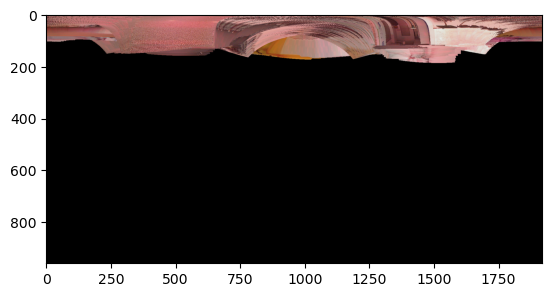

In [36]:
plt.imshow(create_panorama(vicd, cam, False))